# Topic Modeling

In [172]:
import os
import importlib
# import custom vectorizer and associated function
from utils import utilsvectorizer as uv
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
from pyLDAvis.sklearn import prepare

In [143]:
# make sure we have the latest version of custom module loaded
importlib.reload(uv)
# automatically display LDA vis post prepare call
pyLDAvis.enable_notebook()
# pandas display
pd.options.display.float_format = '{:,.2f}'.format
# activate matplotlib and set style
% matplotlib inline
plt.style.use('ggplot')

### Get list of stopwords to remove from corpus

In [65]:
# use stopwords from scikit-learn (list more exhaustive than nltk)
# sw_sklearn = stop_words.ENGLISH_STOP_WORDS
sw = stop_words.ENGLISH_STOP_WORDS

In [49]:
# # read whole file as one string and split on return carriage
# with open(os.path.join(os.pardir, 'data', 'external', 'pi_names.txt')) as f:
#     names_corp = f.read().splitlines()

In [50]:
# add list of investigator names for removal
# sw = sw_sklearn.union(names_corp)

### Read documents along with known topics

In [51]:
topic_dir = os.path.join(os.pardir,'data', 'processed', 'topics.csv')   
# FYI: read_csv() removes quotation marks "
df_full = pd.read_csv(topic_dir, encoding='utf-8', index_col='eff_date', parse_dates=['eff_date'])

In [52]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313975 entries, 1984-11-01 to 2017-11-01
Data columns (total 3 columns):
award_id      313975 non-null int64
org_direct    313975 non-null object
abstract      313975 non-null object
dtypes: int64(1), object(2)
memory usage: 9.6+ MB


In [124]:
# take a subset of abstracts
df_past10 = df_full[df_full.index > '2000-01-01'].copy()
df_past10.drop('award_id', axis = 1, inplace = True)  
df_past10.head()

,org_direct,abstract
eff_date,,
2000-07-15,directorate geosciences,Project Abstract Management and Operations of ...
2000-06-01,directorate social behavioral economic sciences,"This project has two elements. First, it propo..."
2000-03-01,directorate geosciences,A near-bottom geological and geophysical surve...
2000-12-15,directorate geosciences,"Over the past decade, biologists have learned ..."
2000-01-15,directorate geosciences,A near-bottom geological and geophysical surve...


In [125]:
df_past10.shape

(203665, 2)

### Topic distribution

In [192]:
# minimize topic naming convention by removing directorate
df_past10.org_direct = df_past10.org_direct.str.replace('directorate', '')
# abbreviate sciences unless it is part of geociences
df_past10.org_direct = df_past10.org_direct.str.replace(r'\bsciences?', 'sci')

In [193]:
s_directorate = df_past10.org_direct.value_counts(normalize=True)
s_directorate

 mathematical physical sci              0.21
 engineering                            0.19
 geosciences                            0.15
 computer information sci engineering   0.14
 biological sci                         0.13
 social behavioral economic sci         0.09
 education human resources              0.09
Name: org_direct, dtype: float64

In [134]:
# recored number of directorate (i.e. number of topics)
num_direct = s_directorate.count()

### Train-Test split

In [194]:
# split documents in train/test, labels are optional here. It turns out we know them.
train_docs, test_docs = train_test_split( df_past10,
                                    test_size = 0.1,
                                    random_state = 7,
                                    stratify = df_past10.org_direct)

### CountVectorizer to derive document-term matrix (aka document-token)

In [130]:
# custom vectorizer is needed to lemmatize (see utilsvectorizer module)
vecto = uv.CustomVectorizer(
                            stop_words = sw,
                            lowercase = True,
                            strip_accents = 'unicode',
                            token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
                            preprocessor = uv.rm_tag_http,
                            max_features = 2000)

In [131]:
# produce document-term matrix
train_doc_term_matrix = vecto.fit_transform(train_docs.abstract)
train_doc_term_matrix.shape, type(train_doc_term_matrix)

((183298, 2000), scipy.sparse.csr.csr_matrix)

In [132]:
# apply vectorization on test set
test_doc_term_matrix = vecto.transform(test_docs.abstract)
test_doc_term_matrix.shape, type(test_doc_term_matrix)

((20367, 2000), scipy.sparse.csr.csr_matrix)

### Most Frequent Terms

In [116]:
# recover words
lemmatized_words = vecto.get_feature_names()

In [117]:
# sum doc_term_matrix along rows for each column (i.e. word)
word_freq = train_doc_term_matrix.sum(axis=0)

In [118]:
# convert word_freq from matrix to ndarray and flatten it (ravel is faster than flatten as it returns a view instead of a copy)
# then create a pandas serie for display
s_word_freq = pd.Series( np.asarray(word_freq).ravel(), index = lemmatized_words )
# display top words
s_word_freq.sort_values(ascending=False).head(10)

research    477363
project     392275
student     294139
new         195253
data        188707
study       186687
science     168747
model       164967
program     154285
ha          133485
dtype: int64

### Run Latent Dirichlet Analysis

In [78]:
# run LDA with 7 components until perplexity reach plateau
lda_all = LatentDirichletAllocation(n_components = num_direct,
                                    max_iter = 500,
                                    learning_method = 'batch',
                                    evaluate_every = 10,
                                    random_state = 42,
                                    verbose = 1,
                                    n_jobs = -1)
lda_all.fit(train_doc_term_matrix)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 849.9744
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 834.5466
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 830.5986
iteration: 31

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=7, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [80]:
# pickle LDA model
joblib.dump(lda_all, os.path.join(os.pardir,'models', 'lda_500_iter.pkl'))

['..\\models\\lda_500_iter.pkl']

### Evaluate fit

In [174]:
train_preds = lda_all.transform(train_doc_term_matrix)
test_preds = lda_all.transform(test_doc_term_matrix)
train_preds.shape, test_preds.shape

((183298, 7), (20367, 7))

In [175]:
topic_labels = ['Topic {}'.format(i) for i in range(1, num_direct+1)]

In [195]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.org_direct)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.org_direct)

In [196]:
# figtrain , axtrain = plt.subplots(figsize = (16, 8))
# train_eval.groupby(level='org_direct').mean().plot.bar(ax = axtrain, title='Avg. Topic Probabilities')
# # axtrain.tick_params(axis = 'x', labelsize=14, rotation = 60)
# _ = axtrain.set_xticklabels(axtrain.get_xticklabels(), ha='right', rotation = 60, fontsize=14)

In [198]:
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
org_direct,,,,,,,
engineering,0.10,0.15,0.22,0.10,0.14,0.16,0.13
biological sci,0.15,0.21,0.12,0.18,0.05,0.07,0.22
geosciences,0.19,0.07,0.00,0.63,0.10,0.00,0.00
education human resources,0.13,0.16,0.09,0.34,0.06,0.16,0.05
engineering,0.09,0.09,0.14,0.37,0.14,0.10,0.07


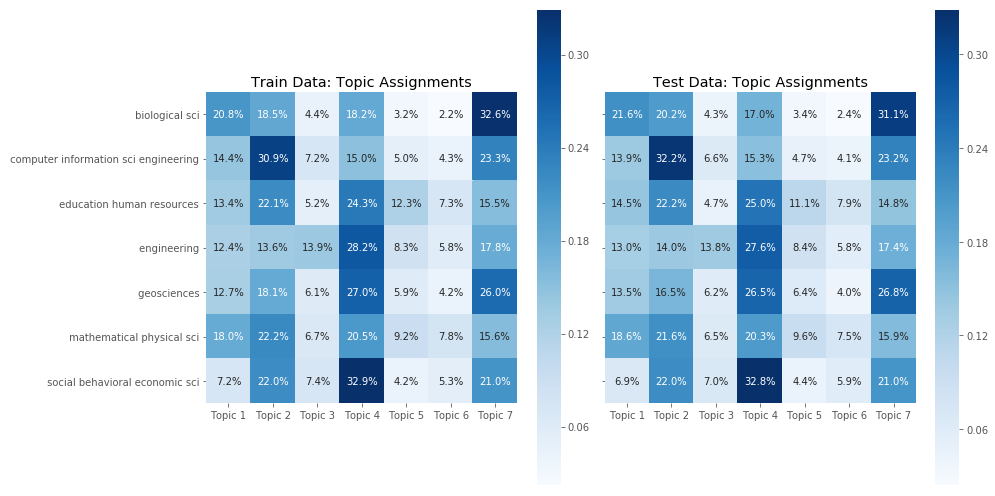

In [218]:
fig, axes = plt.subplots(ncols=2, figsize=(14,7))
source = ['Train', 'Test']

for i, df in enumerate([train_eval, test_eval]):
    
    # generate serie with directorate as index and most probable topic number
    df = df.groupby(level='org_direct').idxmax(axis=1).reset_index(-1, drop=True)
    
    # count how many topic we got right
    sns.heatmap(df.groupby(level='org_direct').value_counts(normalize=True).unstack(-1),
                annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
    axes[i].set_ylabel('')
    
# removes redundant yticklabel for clarity
axes[-1].tick_params(axis = 'y', labelleft = False)
plt.tight_layout()
fig.savefig(os.path.join(os.pardir, 'img', 'Topicassignment.png'))

### Interactive Visualization

In [101]:
# save LDA viz to standalone html
pyLDAvis.save_html(prepare(lda_all, doc_term_matrix, vecto), os.path.join(os.pardir, 'National_Science_Foundation_Award.html'))

In [90]:
# create visualization
prepare(lda_all, doc_term_matrix, vecto)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      19.686857        1       1  0.236995 -0.006451
1      16.390953        1       2  0.016748 -0.133596
2      15.938318        1       3 -0.026511 -0.036530
0      13.968638        1       4 -0.075482  0.099900
6      12.512329        1       5  0.033618  0.050650
3      10.823000        1       6 -0.044486  0.127626
5      10.679905        1       7 -0.140882 -0.101599, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
1776  Default  293647.000000         student  293647.000000  30.0000  30.0000
1134  Default  121095.000000        material  121095.000000  29.0000  29.0000
1842  Default   74863.000000          theory   74863.000000  28.0000  28.0000
1445  Default   87153.000000         problem   87153.000000  27.0000  27.0000
1631  Default  168497.000000         science  168497.000000  26.0000  26.0000
231   Default   58515.000000            cell   58515.000000  25.0000  25.0000
441   Default  188737.000000            data  188737.000000  24.0000  24.0000
1380  Default   42832.000000           plant   42832.000000  23.0000  23.0000
1731  Default   46319.000000          specie   46319.000000  22.0000  22.0000
1475  Default   41107.000000         protein   41107.000000  21.0000  21.0000
1708  Default   46831.000000          social   46831.000000  20.0000  20.0000
1193  Default  165071.000000           model  165071.000000  19.0000  19.0000
1459  Default  154040.000000         program  154040.000000  18.0000  18.0000
268   Default   44386.000000         climate   44386.000000  17.0000  17.0000
1909  Default  117262.000000      university  117262.000000  16.0000  16.0000
1778  Default  186822.000000           study  186822.000000  15.0000  15.0000
484   Default   88298.000000          design   88298.000000  14.0000  14.0000
1966  Default   50248.000000           water   50248.000000  13.0000  13.0000
800   Default   33052.000000            gene   33052.000000  12.0000  12.0000
1990  Default   44957.000000        workshop   44957.000000  11.0000  11.0000
1239  Default   78921.000000         network   78921.000000  10.0000  10.0000
1630  Default   68784.000000          school   68784.000000   9.0000   9.0000
91    Default  100671.000000     application  100671.000000   8.0000   8.0000
1757  Default   44934.000000            stem   44934.000000   7.0000   7.0000
1821  Default   41018.000000         teacher   41018.000000   6.0000   6.0000
1276  Default   33618.000000           ocean   33618.000000   5.0000   5.0000
348   Default   40069.000000      conference   40069.000000   4.0000   4.0000
1828  Default   99539.000000      technology   99539.000000   3.0000   3.0000
584   Default   77364.000000       education   77364.000000   2.0000   2.0000
718   Default   38312.000000         faculty   38312.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
1755   Topic7   14782.024362     statistical   18619.994619   2.0060  -5.3592
1445   Topic7   62048.326305         problem   87153.156993   1.8971  -3.9247
1724   Topic7   24203.870664           space   34810.512404   1.8734  -4.8661
513    Topic7   16120.052139     dimensional   22365.034560   1.9094  -5.2726
1569   Topic7   11481.237581  representation   15274.231151   1.9514  -5.6119
1262   Topic7   13204.002498       numerical   18319.998665   1.9093  -5.4721
333    Topic7   24137.836308   computational   42890.853862   1.6619  -4.8689
1193   Topic7   63467.687526           model  165071.260771   1.2810  -3.9021
1841   Topic7   18527.690578     theoretical   32008.528774   1.6901  -5.1334
1167   Topic7   40593.771546          method  100582.168485   1.3294  -4.3490
1368   Topic7   19100.095277          physic   44523.143891   1.3905  -5.1029
1695   Topic7   16876.657496      simul

In [91]:
prepare(lda_all, doc_term_matrix, vecto, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
4      19.686857        1       1 -160.949310    7.021091
1      16.390953        1       2 -114.442314 -139.357712
2      15.938318        1       3   92.586014   87.572342
0      13.968638        1       4   35.579803 -172.267639
6      12.512329        1       5  139.097321  -58.804596
3      10.823000        1       6  -10.927801  -25.891335
5      10.679905        1       7  -57.435009  120.487465, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
1776  Default  293647.000000         student  293647.000000  30.0000  30.0000
1134  Default  121095.000000        material  121095.000000  29.0000  29.0000
1842  Default   74863.000000          theory   74863.000000  28.0000  28.0000
1445  Default   87153.000000         problem   87153.000000  27.0000  27.0000
1631  Default  168497.000000         science  168497.000000  26.0000  26.0000
231   Default   58515.000000            cell   58515.000000  25.0000  25.0000
441   Default  188737.000000            data  188737.000000  24.0000  24.0000
1380  Default   42832.000000           plant   42832.000000  23.0000  23.0000
1731  Default   46319.000000          specie   46319.000000  22.0000  22.0000
1475  Default   41107.000000         protein   41107.000000  21.0000  21.0000
1708  Default   46831.000000          social   46831.000000  20.0000  20.0000
1193  Default  165071.000000           model  165071.000000  19.0000  19.0000
1459  Default  154040.000000         program  154040.000000  18.0000  18.0000
268   Default   44386.000000         climate   44386.000000  17.0000  17.0000
1909  Default  117262.000000      university  117262.000000  16.0000  16.0000
1778  Default  186822.000000           study  186822.000000  15.0000  15.0000
484   Default   88298.000000          design   88298.000000  14.0000  14.0000
1966  Default   50248.000000           water   50248.000000  13.0000  13.0000
800   Default   33052.000000            gene   33052.000000  12.0000  12.0000
1990  Default   44957.000000        workshop   44957.000000  11.0000  11.0000
1239  Default   78921.000000         network   78921.000000  10.0000  10.0000
1630  Default   68784.000000          school   68784.000000   9.0000   9.0000
91    Default  100671.000000     application  100671.000000   8.0000   8.0000
1757  Default   44934.000000            stem   44934.000000   7.0000   7.0000
1821  Default   41018.000000         teacher   41018.000000   6.0000   6.0000
1276  Default   33618.000000           ocean   33618.000000   5.0000   5.0000
348   Default   40069.000000      conference   40069.000000   4.0000   4.0000
1828  Default   99539.000000      technology   99539.000000   3.0000   3.0000
584   Default   77364.000000       education   77364.000000   2.0000   2.0000
718   Default   38312.000000         faculty   38312.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
1755   Topic7   14782.024362     statistical   18619.994619   2.0060  -5.3592
1445   Topic7   62048.326305         problem   87153.156993   1.8971  -3.9247
1724   Topic7   24203.870664           space   34810.512404   1.8734  -4.8661
513    Topic7   16120.052139     dimensional   22365.034560   1.9094  -5.2726
1569   Topic7   11481.237581  representation   15274.231151   1.9514  -5.6119
1262   Topic7   13204.002498       numerical   18319.998665   1.9093  -5.4721
333    Topic7   24137.836308   computational   42890.853862   1.6619  -4.8689
1193   Topic7   63467.687526           model  165071.260771   1.2810  -3.9021
1841   Topic7   18527.690578     theoretical   32008.528774   1.6901  -5.1334
1167   Topic7   40593.771546          method  100582.168485   1.3294  -4.3490
1368   Topic7   19100.095277          physic   44523.143891   1.3905  -5.1029
169

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

# Notes

In [ ]:
#The default regexp in CountVectorizer() select tokens of 2 or more alphanumeric characters
# (?u) sets flag Unicode dependent, can be done with flag= argument
# \w\w+ any 2 or more alphanumeric characters
# \b matches empty string only at end/beginning of word

In [29]:
# txt_pipe = Pipeline([
#                        ('vecto', uv.CustomVectorizer(
#                                 stop_words = sw,
#                                 strip_accents = 'unicode',
#                                 token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',
#                                 preprocessor = uv.lower_rmtag_rmhttp)),
#                        ('clf', TfidfTransformer()),
#                     ])